In [15]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../../src/')
from train import load_data
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor, Discriminator
import magic
import torch
import pathlib
import copy

import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from omegaconf import OmegaConf
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from geodesic import jacobian, velocity, CondCurve, GeodesicBridgeOverfit
from plotly3d.plot import scatter, trajectories
import torch
from torch import nn
import pytorch_lightning as pl
from procrustes import Procrustes
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from tqdm import tqdm

wandb.login()
api = wandb.Api()

In [10]:
def _distance_to_geodesic_criterion(predicted_geodesic, true_geodesic):
    # the inputs here are single samples from a geodesic; should be shape num_samples x num_dims
    # for each input point, we want the closest distance to any point on the true geodesic using the euclidean distance, torch.cdist
    D = torch.cdist(predicted_geodesic, true_geodesic)
    min_dists_to_true_geodesic = D.min(dim=1)[0]
    # we take the mean of the squared distances
    return torch.mean(min_dists_to_true_geodesic**2)
def distance_to_geodesic_criterion(
    predicted_geodesic:torch.Tensor, # size num_geodesics x num_samples x num_dims
    true_geodesic:torch.Tensor, # size num_geodesics num_samples x num_dims. But it's okay if the num_samples are different
    ):
    """
    Mean of the squared distances from each predicted point to the closest point on the true geodesic
    """
    dists = []
    for i in range(predicted_geodesic.shape[0]):
        dists.append(_distance_to_geodesic_criterion(predicted_geodesic[i], true_geodesic[i]))
    dists = torch.stack(dists)
    return dists.mean()

In [2]:
entity = "xingzhis"
project = "dmae"
sweep_id = '413aez4p'
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

In [6]:
names = df[(df['loss_epoch']!='NaN') & (df['overfit']==False)][['data_name']].values.flatten()

  0%|          | 0/24 [00:00<?, ?it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


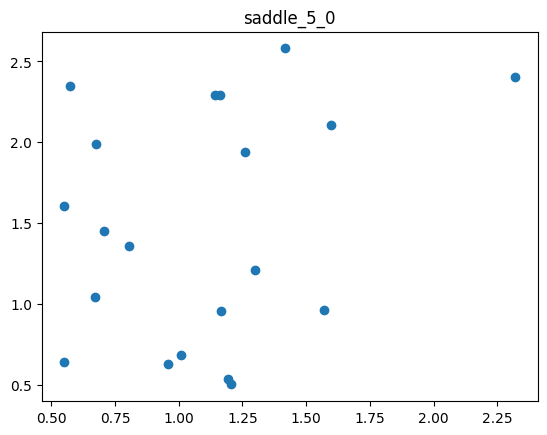

  4%|▍         | 1/24 [00:00<00:14,  1.59it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


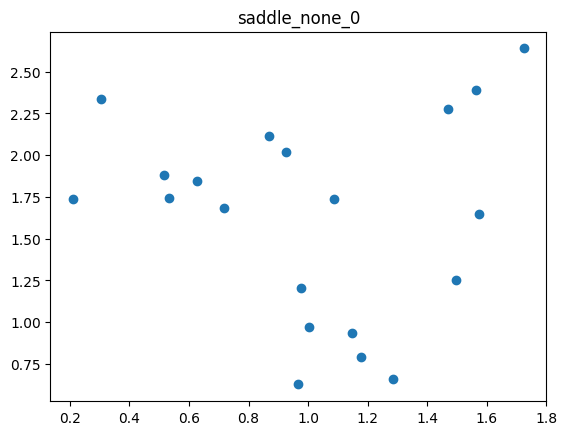

  8%|▊         | 2/24 [00:01<00:12,  1.70it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(
 12%|█▎        | 3/24 [00:01<00:11,  1.75it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


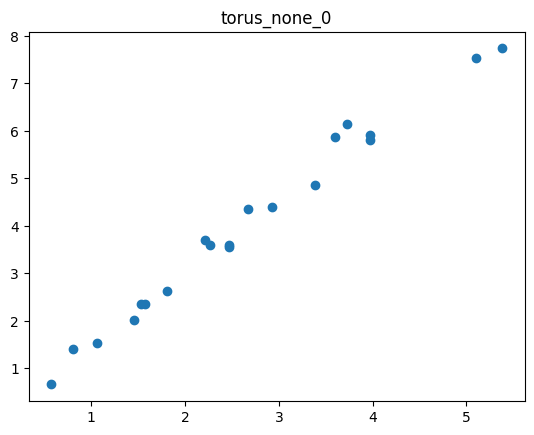

 17%|█▋        | 4/24 [00:02<00:12,  1.60it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


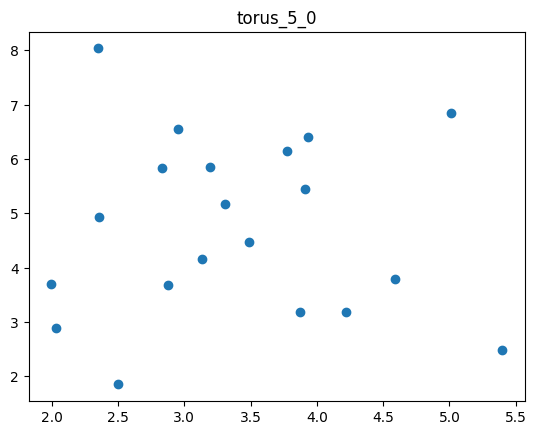

 21%|██        | 5/24 [00:03<00:16,  1.15it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(
 25%|██▌       | 6/24 [00:04<00:13,  1.37it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


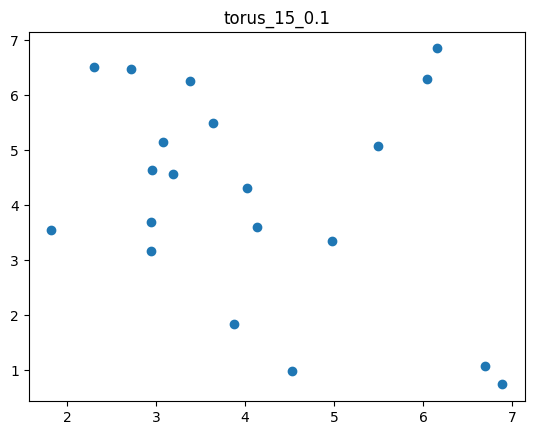

 29%|██▉       | 7/24 [00:05<00:13,  1.26it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


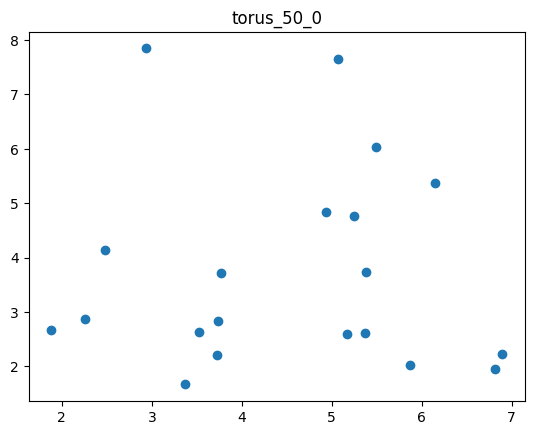

 33%|███▎      | 8/24 [00:06<00:17,  1.11s/it]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


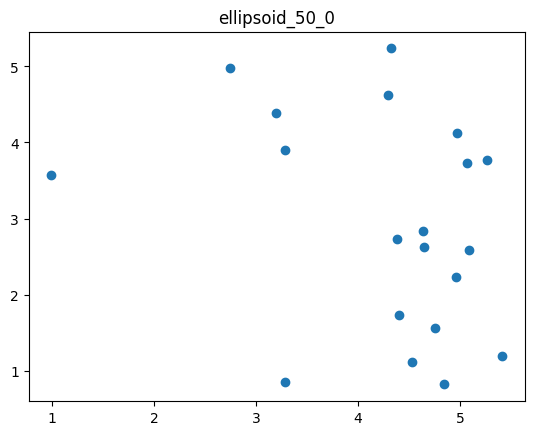

 38%|███▊      | 9/24 [00:08<00:19,  1.31s/it]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


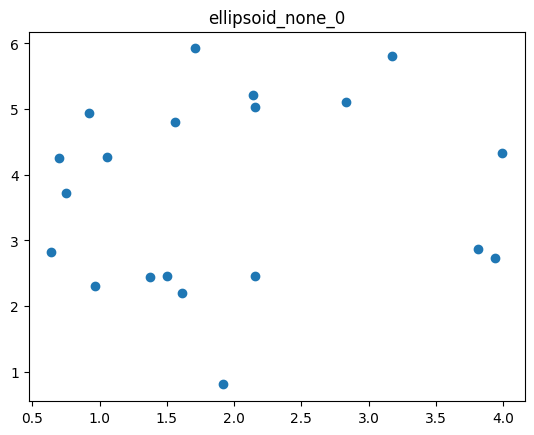

 42%|████▏     | 10/24 [00:09<00:14,  1.07s/it]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


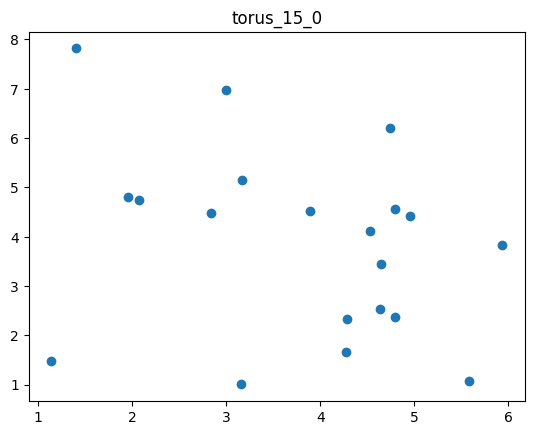

 46%|████▌     | 11/24 [00:09<00:12,  1.03it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(
 50%|█████     | 12/24 [00:10<00:10,  1.17it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(
 54%|█████▍    | 13/24 [00:11<00:09,  1.20it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarnin

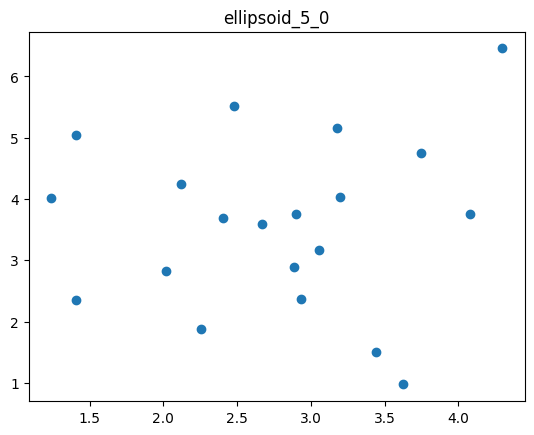

 67%|██████▋   | 16/24 [00:12<00:04,  1.68it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


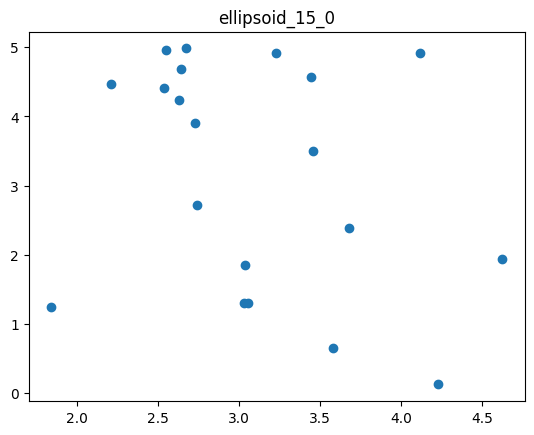

 71%|███████   | 17/24 [00:13<00:04,  1.64it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(
 75%|███████▌  | 18/24 [00:13<00:03,  1.81it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(
 79%|███████▉  | 19/24 [00:14<00:02,  2.10it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarnin

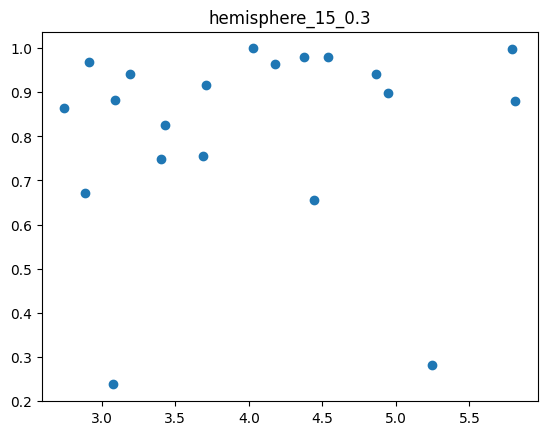

 88%|████████▊ | 21/24 [00:15<00:01,  1.85it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


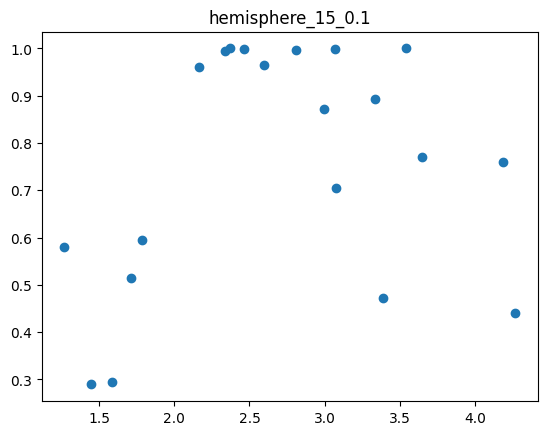

 92%|█████████▏| 22/24 [00:16<00:01,  1.50it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


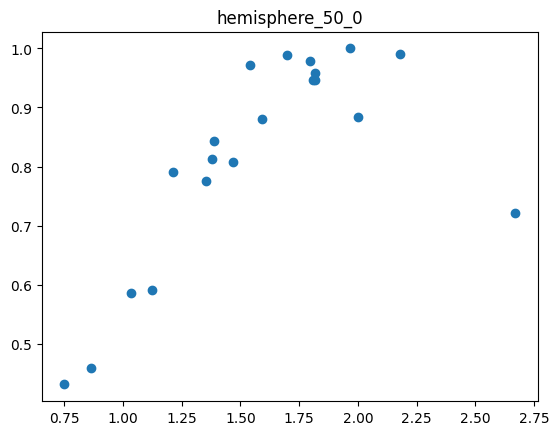

 96%|█████████▌| 23/24 [00:17<00:00,  1.09it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


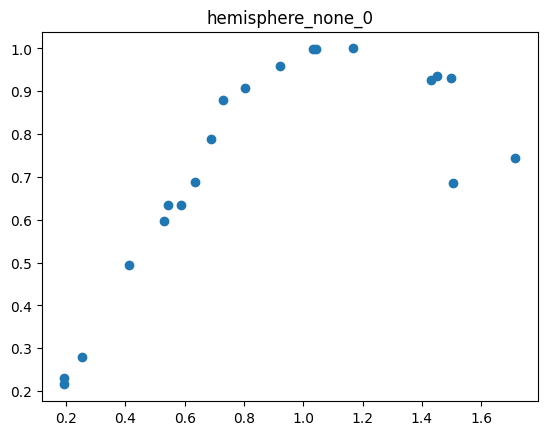

100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


In [27]:

res_list = []

for data_name in tqdm(names):

    entity = "xingzhis"
    project = "dmae"
    sweep_id = '59muwbsf'
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

    runs_data = []

    # Iterate through each run in the sweep
    for run in sweep.runs:
        # Extract metrics and configs
        metrics = run.summary._json_dict
        configs = run.config
        
        # Combine metrics and configs, and add run ID
        combined_data = {**metrics, **configs, "run_id": run.id}
        
        # Append the combined data to the list
        runs_data.append(combined_data)

    # Create a DataFrame from the runs data
    df = pd.DataFrame(runs_data)

    # run_ids = df[(df['data.name'] == data_name) & (df['cfg/loss/weights/cycle'] == 1.) & (df['cfg/dimensions/latent'] == 3)]['run_id']
    run_ids = df[(df['data.name'] == data_name) & (df['loss.weights.cycle'] == 1.0) & (df['dimensions.latent'] == 3)]['run_id']
    assert len(run_ids) == 1
    run_id = run_ids.iloc[0]
    run = api.run(f"{entity}/{project}/{run_id}")
    # run = api.run(f"{entity}/{project}/{run_id}")
    folder_path = '../../src/wandb/'
    cfg = OmegaConf.create(run.config)
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
    cfg.data.root = '../' + cfg.data.root
    model = Autoencoder.load_from_checkpoint(ckpt_path)
    data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)



    sweep_id = 'ywep3ixr'
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
    # Initialize an empty list to store run data
    runs_data = []

    # Iterate through each run in the sweep
    for run in sweep.runs:
        # Extract metrics and configs
        metrics = run.summary._json_dict
        configs = run.config
        
        # Combine metrics and configs, and add run ID
        combined_data = {**metrics, **configs, "run_id": run.id}
        
        # Append the combined data to the list
        runs_data.append(combined_data)

    # Create a DataFrame from the runs data
    df = pd.DataFrame(runs_data)
    run_ids = df[(df['data.name'] == data_name)][['run_id']]
    assert len(run_ids) == 1
    run_id = run_ids.iloc[0]
    run = api.run(f"{entity}/{project}/{run_ids.iloc[0].values[0]}")
    folder_path = '../../src/wandb/'
    cfg = OmegaConf.create(run.config)
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]
    cfg.data.root = '../' + cfg.data.root
    discriminator = Discriminator.load_from_checkpoint(ckpt_path)



    entity = "xingzhis"
    project = "dmae"
    sweep_id = '413aez4p'
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
    runs_data = []

    # Iterate through each run in the sweep
    for run in sweep.runs:
        # Extract metrics and configs
        metrics = run.summary._json_dict
        configs = run.config
        
        # Combine metrics and configs, and add run ID
        combined_data = {**metrics, **configs, "run_id": run.id}
        
        # Append the combined data to the list
        runs_data.append(combined_data)

    # Create a DataFrame from the runs data
    df = pd.DataFrame(runs_data)

    run_ids = df[(df['data_name'] == data_name) & (df['overfit'] == False) & (df['loss_epoch'] != 'NaN')]['run_id']
    assert len(run_ids) == 1
    run_id = run_ids.iloc[0]
    run = api.run(f"{entity}/{project}/{run_id}")
    cfg_main = OmegaConf.create(run.config)
    folder_path = './wandb/'
    folder_list = glob.glob(f"{folder_path}*{run.id}*")
    ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
    ckpt_path = ckpt_files[0]

    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    xbatch = torch.tensor(data['start_points'], dtype=x.dtype, device=x.device)
    xendbatch = torch.tensor(data['end_points'], dtype=x.dtype, device=x.device)
    xbatch = model.encoder.preprocessor.normalize(xbatch)
    xendbatch = model.encoder.preprocessor.normalize(xendbatch)
    if cfg_main.overfit:
        ids = torch.eye(xbatch.size(0))
    else:
        ids = torch.zeros((xbatch.size(0),1))
    dataset = TensorDataset(xbatch, xendbatch, ids)
    dataloader = DataLoader(dataset, batch_size=len(x), shuffle=False)

    for param in model.encoder.parameters():
        param.requires_grad = False
    def func(x):
        return model.encoder(x)
    for param in discriminator.parameters():
        param.requires_grad = False
    def discriminator_func_for_grad(x):
        return discriminator.positive_proba(x, normalize=False).reshape(-1,1)
    def discriminator_func(x):
        return discriminator.positive_proba(x, normalize=False).reshape(-1,1)

    gbmodel = GeodesicBridgeOverfit.load_from_checkpoint(
        checkpoint_path=ckpt_path,
        func=func,
        input_dim=x.size(1), 
        hidden_dim=32, 
        scale_factor=1, 
        symmetric=True, 
        num_layers=2, 
        n_tsteps=20, 
        lr=1e-3, 
        weight_decay=1e-5,
        discriminator_func_for_grad=discriminator_func_for_grad,
        discriminator_func_for_grad_weight=4.,
        length_weight=0.,
        discriminator_func=discriminator_func,
        discriminator_weight=8.,
        points_penalty_alpha=4.,
        density_weight=0.,
        n_topk=10,
        points_penalty_power=4,
        points_penalty_density=False,
        points_penalty_disc=False,
        points_penalty_grad=True,
        disc_use_max=False,
        id_dim=20 if cfg_main.overfit else 1,  # learn an embedding for each curve, to overfit the model to each curve.
        id_emb_dim=8 if cfg_main.overfit else 1,
        multiply_loss=True,
        # multiply_loss=False,
        cc_k=2,
        data_pts=x
    )

    batch = next(iter(dataloader))
    x0, x1, ids = batch
    def cc_func(x0, x1, t):
        return gbmodel.cc(x0, x1, t, ids)
    vectors = velocity(cc_func, gbmodel.ts, x0, x1)
    cc_pts = gbmodel.cc(x0, x1, gbmodel.ts, ids)
    vectors_flat = vectors.flatten(0,1)
    cc_pts_flat = cc_pts.flatten(0, 1)
    jac_flat = jacobian(gbmodel.func, cc_pts_flat)
    # length_all = torch.sqrt((torch.einsum("nij,nj->ni", jac_flat, vectors_flat)**2).sum(axis=1))
    # length_all = length_all.reshape(vectors.shape[0], vectors.shape[1])
    # length = length_all.mean(axis=0)

    geods = model.encoder.preprocessor.unnormalize(cc_pts_flat).reshape(cc_pts.shape)
    length2 = torch.sqrt(torch.diff(geods, axis=0)**2).sum(axis=-1).sum(axis=0)/2

    try:
        if data_name.startswith('hemisphere'):
            data_gt = np.load(f"../../data/gt_geodesic/{data_name}.npz", allow_pickle=True)
        else:
            data_gt = np.load(f"../../data/gt_geodesic_w_geod_2//{data_name}.npz", allow_pickle=True)
    except:
        continue
    plt.scatter(length2.detach().numpy(), data_gt['geodesic_lengths'])
    plt.title(data_name)
    plt.show()

    corr = np.corrcoef(length2.detach().numpy(), data_gt['geodesic_lengths'])[0,1]
    mse = ((length2.detach().numpy() - data_gt['geodesic_lengths'])**2).mean()
    dist2geod = distance_to_geodesic_criterion(geods, torch.tensor(data_gt['geodesics'], dtype=torch.float32)).detach().numpy()

    res_list.append(dict(
        name=data_name,
        length_corr=corr,
        length_mse=mse,
        dist2geod=dist2geod
    ))

In [28]:
res_df = pd.DataFrame(res_list)

In [29]:
res_df.sort_values('length_corr', ascending=False)

,name,length_corr,length_mse,dist2geod
2,torus_none_0,0.992421,2.304452,6.3342257
14,hemisphere_none_0,0.719610,0.128178,0.7936704
13,hemisphere_50_0,0.680260,0.698039,0.85690784
12,hemisphere_15_0.1,0.270687,4.480565,1.2865268
0,saddle_5_0,0.263335,0.660991,0.604114
11,hemisphere_15_0.3,0.102314,11.106132,2.3126874
7,ellipsoid_none_0,0.096288,5.941719,4.0544014
9,ellipsoid_5_0,0.087975,3.051960,4.512555
5,torus_50_0,-0.009886,5.974256,5.96576
3,torus_5_0,-0.018060,5.328210,5.627301
